# Setup


In [1]:
import matplotlib.pyplot as plt
import torch
from mattn import *

2025-05-10 07:29:07.983337: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 07:29:07.997185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746862148.013661   31475 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746862148.019017   31475 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-10 07:29:08.035969: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
def ema_smooth(y, alpha=0.1):
    smoothed = []
    for i, val in enumerate(y):
        if i == 0:
            smoothed.append(val)
        else:
            smoothed.append(alpha * val + (1 - alpha) * smoothed[-1])
    return smoothed

# "Easy Dataset"


In [3]:
epochs = 50_000

In [4]:
inputs, embedding_dim = load_inputs("../data/wikipedia-v1-plain-query/inputs")

Loaded 9000 inputs.


In [5]:
torch.manual_seed(42)
plain_ff_model = FeedForwardRelevanceModel(embedding_dim=embedding_dim, hidden_dim=128)
plain_ff_l1_result = train(
    plain_ff_model, inputs, "l1", epochs=epochs, lr=1e-3, one_of_n=[3, 10]
)
plain_ff_mse_result = train(
    plain_ff_model, inputs, "mse", epochs=epochs, lr=1e-3, one_of_n=[3, 10]
)

Train size: 8100, Test size: 900


Training: 100%|██████████| 50000/50000 [01:56<00:00, 429.00it/s]



Train size: 8100, Test size: 900


Training: 100%|██████████| 50000/50000 [01:55<00:00, 434.09it/s]


In [6]:
latent_dims = [2, 4, 8, 16]
plain_le_results = []
for d in latent_dims:
    torch.manual_seed(42)
    model = LatentEmbeddingRelevanceModel(
        embedding_dim=embedding_dim, latent_dim=d, hidden_dim=128
    )
    result = train(model, inputs, "l1", epochs=epochs, lr=1e-4, one_of_n=[30])
    plain_le_results.append(result)

Train size: 8100, Test size: 900


Training: 100%|██████████| 50000/50000 [02:56<00:00, 283.30it/s]



Train size: 8100, Test size: 900


Training: 100%|██████████| 50000/50000 [02:56<00:00, 283.97it/s]



Train size: 8100, Test size: 900


Training: 100%|██████████| 50000/50000 [02:56<00:00, 283.04it/s]


Train size: 8100, Test size: 900


Training: 100%|██████████| 50000/50000 [02:58<00:00, 280.90it/s]


In [7]:
torch.manual_seed(42)
plain_cs_model = CosineSimilarityRelevanceModel()
plain_cs_result = train(
    plain_cs_model, inputs, "l1", epochs=1000, lr=1e-1, one_of_n=[3, 10]
)

Train size: 8100, Test size: 900


Training: 100%|██████████| 1000/1000 [00:01<00:00, 547.16it/s]



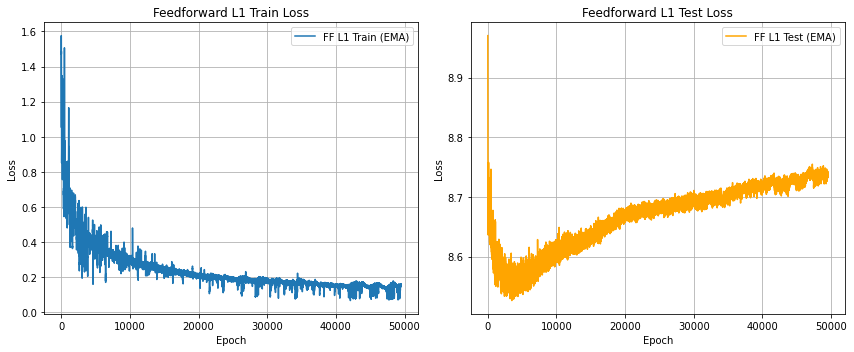

In [22]:
# Remove first few losses from each series
plain_ff_l1_train = plain_ff_l1_result.train_losses[500:]
plain_ff_l1_test = plain_ff_l1_result.test_losses[500:]

# Plot train and test loss curves for feedforward L1 model in 1x2 subplots (stacked horizontally)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# FF L1 Train Loss
axes[0].plot(ema_smooth(plain_ff_l1_train), label="FF L1 Train (EMA)")
axes[0].set_title("Feedforward L1 Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# FF L1 Test Loss
axes[1].plot(ema_smooth(plain_ff_l1_test), label="FF L1 Test (EMA)", color="orange")
axes[1].set_title("Feedforward L1 Test Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("plain_ff_l1_loss.pdf")
plt.show()

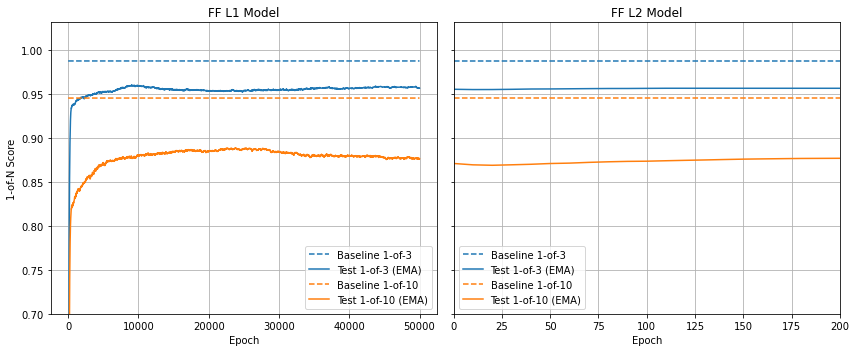

In [23]:
# Plot one_of_n scores for FF L1 and FF MSE models in two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

n_values = [3, 10]
colors = plt.cm.tab10.colors  # Use tab10 colormap for up to 10 distinct colors

# Left: FF L1 model
for idx, n in enumerate(n_values):
    color = colors[idx % len(colors)]
    axes[0].plot(
        plain_ff_l1_result.plot_range,
        [plain_cs_result.one_of_n_tests[n][0]] * len(plain_ff_l1_result.plot_range),
        linestyle="--",
        label=f"Baseline 1-of-{n}",
        color=color,
    )
    axes[0].plot(
        plain_ff_l1_result.plot_range,
        ema_smooth(plain_ff_l1_result.one_of_n_tests[n]),
        label=f"Test 1-of-{n} (EMA)",
        color=color,
    )
axes[0].set_title("FF L1 Model")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("1-of-N Score")
axes[0].set_ylim(bottom=0.7)
axes[0].legend()
axes[0].grid(True)

# Right: FF MSE model
for idx, n in enumerate(n_values):
    color = colors[idx % len(colors)]
    axes[1].plot(
        plain_ff_mse_result.plot_range,
        [plain_cs_result.one_of_n_tests[n][0]] * len(plain_ff_mse_result.plot_range),
        linestyle="--",
        label=f"Baseline 1-of-{n}",
        color=color,
    )
    axes[1].plot(
        plain_ff_mse_result.plot_range,
        ema_smooth(plain_ff_mse_result.one_of_n_tests[n]),
        label=f"Test 1-of-{n} (EMA)",
        color=color,
    )
axes[1].set_title("FF L2 Model")
axes[1].set_xlabel("Epoch")
axes[1].set_xlim(left=0, right=200)
axes[1].set_ylim(bottom=0.7)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("plain_ff_score.pdf")
plt.show()

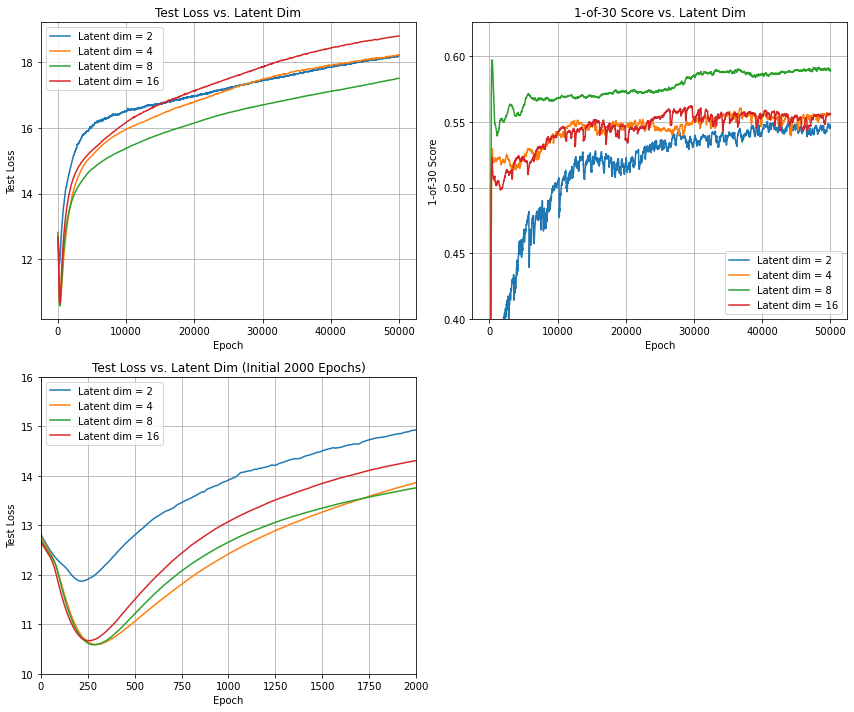

In [24]:
# Plot test losses and 1-of-30 scores for different latent_dims (with EMA smoothing)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

latent_dim_labels = [str(d) for d in latent_dims]
colors = plt.cm.tab10.colors

# Top left: Test losses (EMA)
for idx, (result, label) in enumerate(zip(plain_le_results, latent_dim_labels)):
    axes[0, 0].plot(
        result.plot_range,
        ema_smooth(result.test_losses[::10]),
        label=f"Latent dim = {label}",
        color=colors[idx % len(colors)],
    )
axes[0, 0].set_title("Test Loss vs. Latent Dim")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Test Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Top right: 1-of-30 scores (EMA)
for idx, (result, label) in enumerate(zip(plain_le_results, latent_dim_labels)):
    axes[0, 1].plot(
        result.plot_range,
        ema_smooth(result.one_of_n_tests[30]),
        label=f"Latent dim = {label}",
        color=colors[idx % len(colors)],
    )
axes[0, 1].set_title("1-of-30 Score vs. Latent Dim")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("1-of-30 Score")
axes[0, 1].set_ylim(bottom=0.4)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Bottom (left): Test losses (EMA), xlim 0-2000
for idx, (result, label) in enumerate(zip(plain_le_results, latent_dim_labels)):
    axes[1, 0].plot(
        result.plot_range,
        ema_smooth(result.test_losses[::10]),
        label=f"Latent dim = {label}",
        color=colors[idx % len(colors)],
    )
axes[1, 0].set_title("Test Loss vs. Latent Dim (Initial 2000 Epochs)")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Test Loss")
axes[1, 0].set_xlim(0, 2000)
axes[1, 0].set_ylim(bottom=10, top=16)
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].axis("off")  # Hide the bottom right subplot

plt.tight_layout()
plt.savefig("plain_latent_dim.pdf")
plt.show()

# "Hard Dataset"


In [11]:
epochs = 50_000

In [12]:
inputs, embedding_dim = load_inputs("../data/wikipedia-v2-unrelated-query/inputs")

Loaded 15000 inputs.


In [13]:
torch.manual_seed(42)
unrelated_ff_model = FeedForwardRelevanceModel(
    embedding_dim=embedding_dim, hidden_dim=128
)
unrelated_ff_l1_result = train(
    unrelated_ff_model, inputs, "l1", epochs=epochs, lr=1e-3, one_of_n=[3, 10]
)
unrelated_ff_mse_result = train(
    unrelated_ff_model, inputs, "mse", epochs=epochs, lr=1e-3, one_of_n=[3, 10]
)

Train size: 13500, Test size: 1500


Training: 100%|██████████| 50000/50000 [02:35<00:00, 320.56it/s]



Train size: 13500, Test size: 1500


Training: 100%|██████████| 50000/50000 [02:35<00:00, 321.48it/s]


In [14]:
latent_dims = [2, 4, 8, 16]
unrelated_le_results = []
for d in latent_dims:
    torch.manual_seed(42)
    model = LatentEmbeddingRelevanceModel(
        embedding_dim=embedding_dim, latent_dim=d, hidden_dim=128
    )
    result = train(model, inputs, "l1", epochs=epochs, lr=1e-4, one_of_n=[30])
    unrelated_le_results.append(result)

Train size: 13500, Test size: 1500


Training: 100%|██████████| 50000/50000 [04:00<00:00, 208.14it/s]



Train size: 13500, Test size: 1500


Training: 100%|██████████| 50000/50000 [03:59<00:00, 208.39it/s]


Train size: 13500, Test size: 1500


Training: 100%|██████████| 50000/50000 [04:00<00:00, 208.11it/s]


Train size: 13500, Test size: 1500


Training: 100%|██████████| 50000/50000 [03:58<00:00, 209.38it/s]


In [15]:
torch.manual_seed(42)
unrelated_cs_model = CosineSimilarityRelevanceModel()
unrelated_cs_result = train(
    unrelated_cs_model, inputs, "l1", epochs=1000, lr=1e-1, one_of_n=[3, 10]
)

Train size: 13500, Test size: 1500


Training: 100%|██████████| 1000/1000 [00:02<00:00, 383.42it/s]


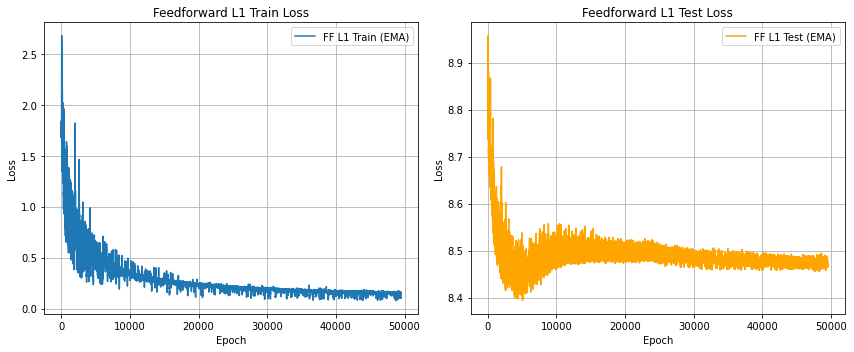

In [25]:
# Remove first few losses from each series
unrelated_ff_l1_train = unrelated_ff_l1_result.train_losses[500:]
unrelated_ff_l1_test = unrelated_ff_l1_result.test_losses[500:]

# Plot train and test loss curves for feedforward L1 model in 1x2 subplots (stacked horizontally)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# FF L1 Train Loss
axes[0].plot(ema_smooth(unrelated_ff_l1_train), label="FF L1 Train (EMA)")
axes[0].set_title("Feedforward L1 Train Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].legend()
axes[0].grid(True)

# FF L1 Test Loss
axes[1].plot(ema_smooth(unrelated_ff_l1_test), label="FF L1 Test (EMA)", color="orange")
axes[1].set_title("Feedforward L1 Test Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("unrelated_ff_l1_loss.pdf")
plt.show()

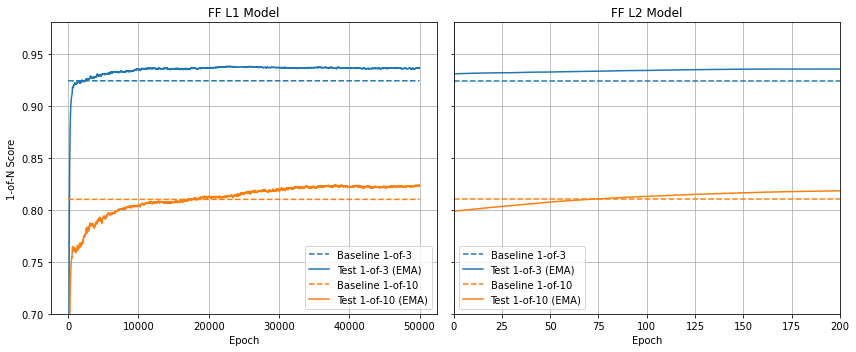

In [26]:
# Plot one_of_n scores for FF L1 and FF MSE models in two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

n_values = [3, 10]
colors = plt.cm.tab10.colors  # Use tab10 colormap for up to 10 distinct colors

# Left: FF L1 model
for idx, n in enumerate(n_values):
    color = colors[idx % len(colors)]
    axes[0].plot(
        unrelated_ff_l1_result.plot_range,
        [unrelated_cs_result.one_of_n_tests[n][0]]
        * len(unrelated_ff_l1_result.plot_range),
        linestyle="--",
        label=f"Baseline 1-of-{n}",
        color=color,
    )
    axes[0].plot(
        unrelated_ff_l1_result.plot_range,
        ema_smooth(unrelated_ff_l1_result.one_of_n_tests[n]),
        label=f"Test 1-of-{n} (EMA)",
        color=color,
    )
axes[0].set_title("FF L1 Model")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("1-of-N Score")
axes[0].set_ylim(bottom=0.7)
axes[0].legend()
axes[0].grid(True)

# Right: FF MSE model
for idx, n in enumerate(n_values):
    color = colors[idx % len(colors)]
    axes[1].plot(
        unrelated_ff_mse_result.plot_range,
        [unrelated_cs_result.one_of_n_tests[n][0]]
        * len(unrelated_ff_mse_result.plot_range),
        linestyle="--",
        label=f"Baseline 1-of-{n}",
        color=color,
    )
    axes[1].plot(
        unrelated_ff_mse_result.plot_range,
        ema_smooth(unrelated_ff_mse_result.one_of_n_tests[n]),
        label=f"Test 1-of-{n} (EMA)",
        color=color,
    )
axes[1].set_title("FF L2 Model")
axes[1].set_xlabel("Epoch")
axes[1].set_xlim(left=0, right=200)
axes[1].set_ylim(bottom=0.7)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("unrelated_ff_score.pdf")
plt.show()

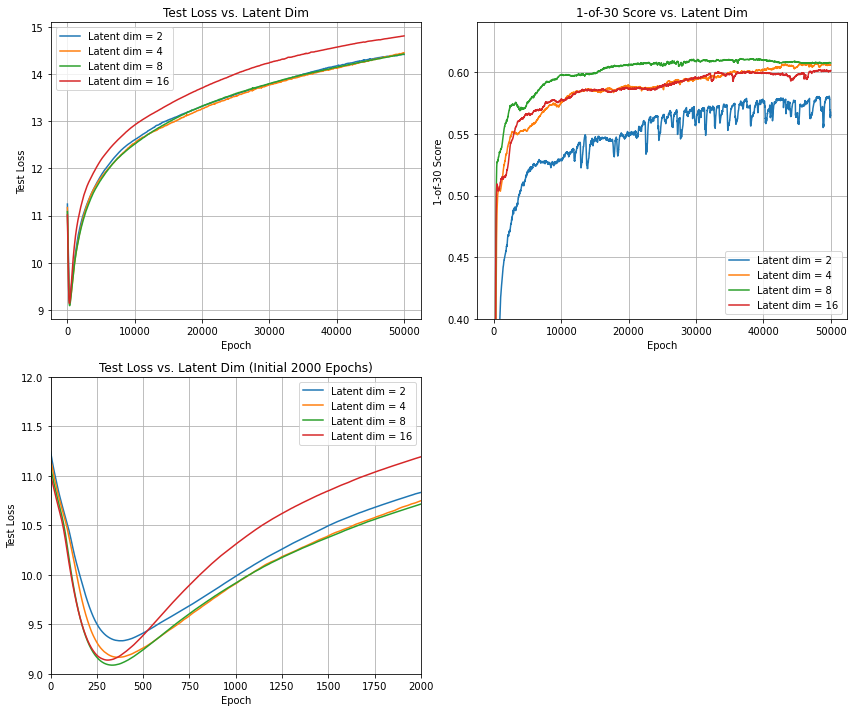

In [27]:
# Plot test losses and 1-of-30 scores for different latent_dims (with EMA smoothing)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

latent_dim_labels = [str(d) for d in latent_dims]
colors = plt.cm.tab10.colors

# Top left: Test losses (EMA)
for idx, (result, label) in enumerate(zip(unrelated_le_results, latent_dim_labels)):
    axes[0, 0].plot(
        result.plot_range,
        ema_smooth(result.test_losses[::10]),
        label=f"Latent dim = {label}",
        color=colors[idx % len(colors)],
    )
axes[0, 0].set_title("Test Loss vs. Latent Dim")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Test Loss")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Top right: 1-of-30 scores (EMA)
for idx, (result, label) in enumerate(zip(unrelated_le_results, latent_dim_labels)):
    axes[0, 1].plot(
        result.plot_range,
        ema_smooth(result.one_of_n_tests[30]),
        label=f"Latent dim = {label}",
        color=colors[idx % len(colors)],
    )
axes[0, 1].set_title("1-of-30 Score vs. Latent Dim")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("1-of-30 Score")
axes[0, 1].set_ylim(bottom=0.4)
axes[0, 1].legend()
axes[0, 1].grid(True)

# Bottom (left): Test losses (EMA), xlim 0-2000
for idx, (result, label) in enumerate(zip(unrelated_le_results, latent_dim_labels)):
    axes[1, 0].plot(
        result.plot_range,
        ema_smooth(result.test_losses[::10]),
        label=f"Latent dim = {label}",
        color=colors[idx % len(colors)],
    )
axes[1, 0].set_title("Test Loss vs. Latent Dim (Initial 2000 Epochs)")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Test Loss")
axes[1, 0].set_xlim(0, 2000)
axes[1, 0].set_ylim(bottom=9, top=12)
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].axis("off")  # Hide the bottom right subplot

plt.tight_layout()
plt.savefig("unrelated_latent_dim.pdf")
plt.show()